# Change in Biodiversity Intactness in Phoenix
Author: Ian Morris-Sibaja

Full Repository: https://github.com/imsibaja/bii-phx

## About
### Purpose:
This repository contains notebooks `bii-phx.ipynb` whose goal is to analyze the effects of urban sprawl on biodiversity and ecosystem health in the Phoenix metropolitan area. Over the past decades, Phoenix has had one of the fastest and largest population growth in the country. With only a preliminary understanding, we do not know the full scope of the environmental effects this will cascade within the area. With this analysis, we begin to chip away at the question: How does urban sprawl affect biodiversity?

### Highlights:

- Integration of Microsoft Biodiversity Data via API
- Spatiotemporal analysis of biodiversity rasters
- Perform bitwise operations and raster algebra 
- Visualize biodiversity loss within the Phoenix metropolitan area

### About the Data:

All data is housed within the repository and will run with the proper packages installed. To access the data, run the notebook cell by cell. For more information on the data, refer to the citations below.

#### Arizona Shapefiles
The U.S. Census Bureau's TIGER/Line Arizona Shapefile is a set of shapefiles that outline boundaries within the state of Arizona. These files are publicly available and widely used for mapping, spatial analysis, and geographic information system (GIS) applications. Information such as counties, cities, census tracts and districts, roads, rivers, and lakes is included. 

#### Biodiversity Intactness Index (BII)
This dataset consists of maps of global biodiversity intactness. This Microsoft Planetary Computer STAC Collection builds models of biodiversity and human relationships. The BII is modeled from abundance and compositional similarity. This dataset will help us visualize and analyze the change in biodiversity intactness through the years.intactness through the years.

### References
United States Census Bureau [2020 TIGER/Line Shapefiles](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions)

Microsoft Planetary Computer STAC catalog [Biodiversity Intactness Index (BII)](https://planetarycomputer.microsoft.com/dataset/io-biodiversity)

- Z. Levitt and J. Eng, “Where America’s developed areas are growing: ‘Way off into the horizon’,” The Washington Post, Aug. 2021, Available: https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/. [Accessed: Nov. 22, 2024]
- F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” Aug. 2022. Available: https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf

Galaz García, Carmen. Assignment4 – EDS 220 - Working with Environmental Datasets. (n.d.). https://meds-eds-220.github.io/MEDS-eds-220-course/assignments/final-project

## Import data and packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr

from pystac_client import Client 
import planetary_computer 
from IPython.display import Image 
import contextily as cx
import matplotlib.patches as mpatches

from IPython.display import HTML
import requests
import base64

### Import the Arizona shapefile

In [2]:
az_shp = gpd.read_file("data/tl_2020_04_cousub.shp")

### Import Biodiversity collection

In [3]:
# Connect to Biodiversity API
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Filter Biodiveristy collection
ib_collection = catalog.get_child('io-biodiversity')
ib_collection

<CollectionClient id=io-biodiversity>

In [4]:
# Phoenix bounding box
phx_bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 32.974108],
            [-112.826843, 33.863574],
            [-111.184387, 33.863574],
            [-111.184387, 32.974108],
            [-112.826843, 32.974108]
        ]
    ],
}

# Time range of interest
time_range = "2017-01-01/2021-01-01"

In [5]:
# Search for raster within our scope
search = catalog.search(
    collections=["io-biodiversity"],
    intersects=phx_bbox,
    datetime=time_range
)
items = search.item_collection()
items

In [6]:
# Select years 2020 and 2017

# 2020 Raster
item_2020 = items[0]

# 2017 Raster
item_2017 = items[3]

## Biodiversity Data Exploration

With our biodiversity rasters loaded, we can view what data is associated with each item.

In [7]:
# View titles of asserts
for key in item_2020.assets.keys():
    print(key, "--", item_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [8]:
for key in item_2017.assets.keys():
    print(key, "--", item_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


Let's view the rendered previews of each item.


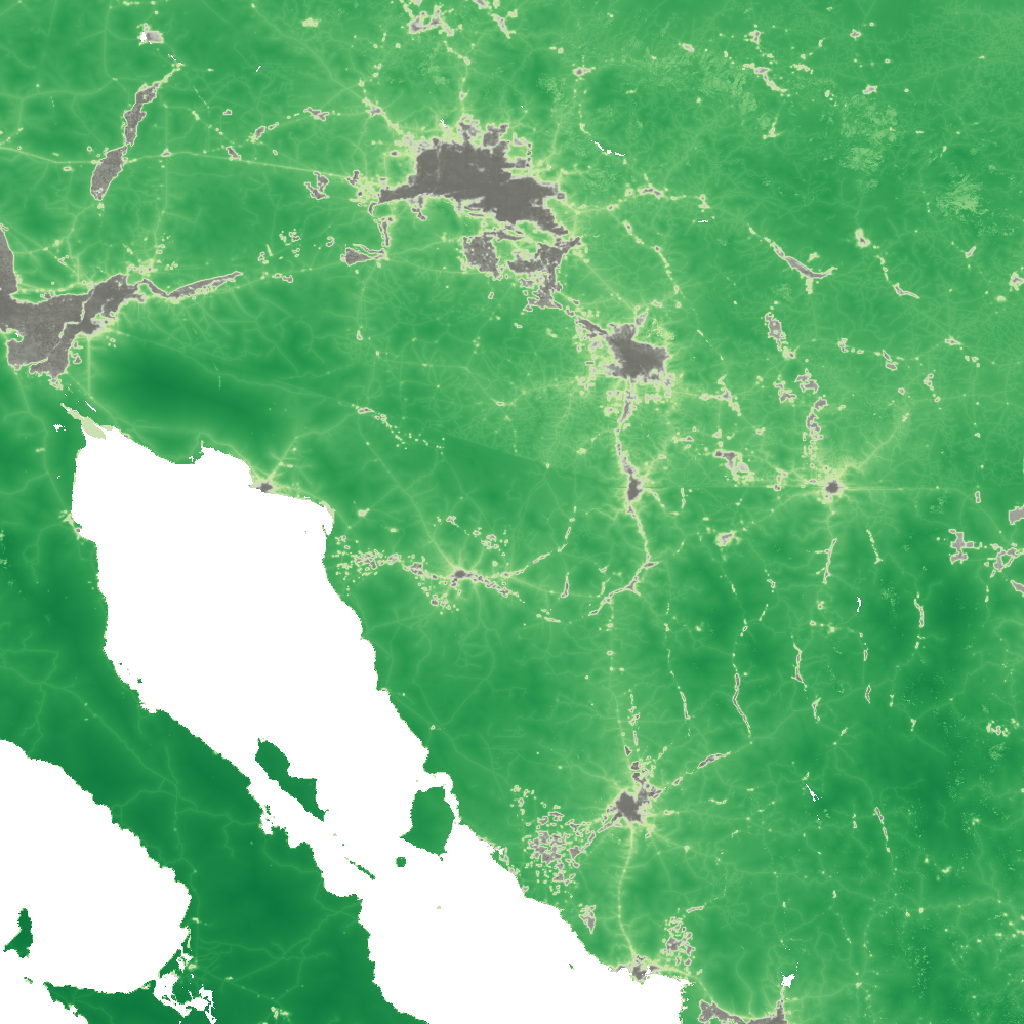

In [9]:
# Preview 2017
image_url = item_2017.assets['rendered_preview'].href
response = requests.get(image_url)

base64_image = base64.b64encode(response.content).decode('utf-8')

display(HTML(f'''
    <!DOCTYPE html>
    <html>
    <head><meta charset="UTF-8"></head>
    <body>
        <img src="data:image/png;base64,{base64_image}" alt="Safe Base64 Image Preview" width="500">
    </body>
    </html>
'''))



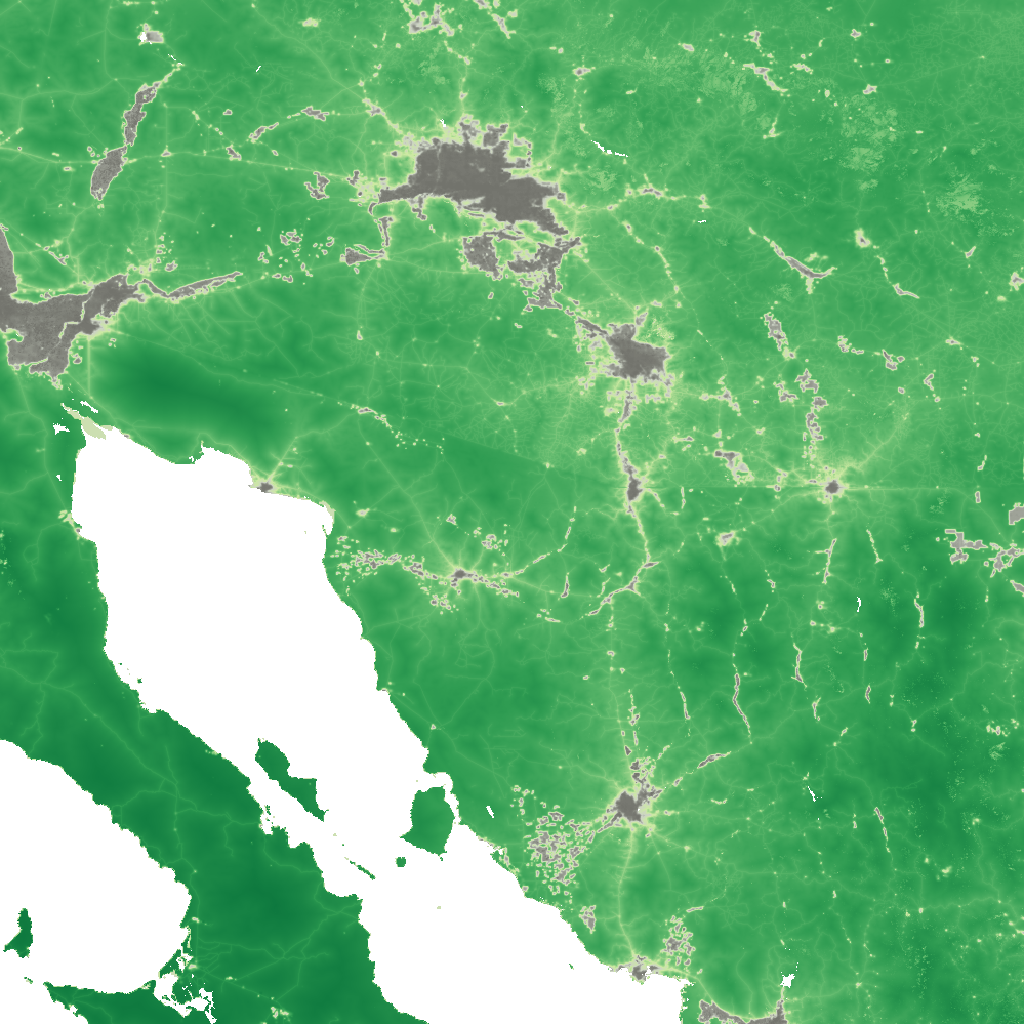

In [10]:
# Preview 2020
image_url = item_2020.assets['rendered_preview'].href
response = requests.get(image_url)
base64_image = base64.b64encode(response.content).decode('utf-8')

display(HTML(f'''
    <!DOCTYPE html>
    <html>
    <head><meta charset="UTF-8"></head>
    <body>
        <img src="data:image/png;base64,{base64_image}" alt="Safe Base64 Image Preview" width="500">
    </body>
    </html>
'''))


### Phoenix Shapefile Exploration

Here, we explore the Arizona Shapefile. First we can view the original, unedited data.

In [11]:
# View first five rows of gdf
az_shp.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,015,91964,02582914,0401591964,Lake Havasu City,Lake Havasu City CCD,22,Z5,G4040,None,None,None,S,7493863105,50863803,+34.7686221,-113.8749805,"POLYGON ((-114.48778 34.71722, -114.48622 34.7..."
1,04,007,91277,02582913,0400791277,Fort Apache,Fort Apache CCD,22,Z5,G4040,None,None,None,S,2134058292,4388167,+33.8847663,-110.3394452,"POLYGON ((-110.78327 34.16750, -110.78276 34.1..."
2,04,003,90306,01934923,0400390306,Bisbee,Bisbee CCD,22,Z5,G4040,None,None,None,S,1610943633,3494169,+31.4580397,-110.0783372,"POLYGON ((-110.46089 31.47376, -110.46089 31.4..."
3,04,003,90408,01934925,0400390408,Bowie,Bowie CCD,22,Z5,G4040,None,None,None,S,3556140749,1110460,+32.1699052,-109.3999964,"POLYGON ((-109.76866 32.30583, -109.76787 32.3..."
4,04,003,93825,01934992,0400393825,Willcox,Willcox CCD,22,Z5,G4040,None,None,None,S,1898081614,4959613,+32.1980984,-109.8877527,"POLYGON ((-110.15218 32.17203, -110.15213 32.1..."


<Axes: >

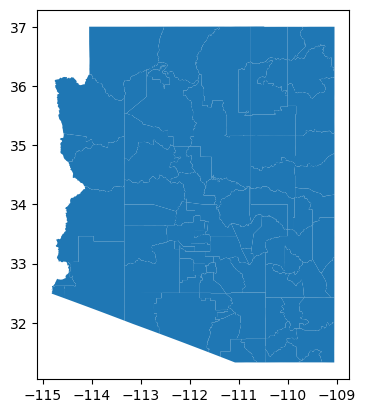

In [12]:
# View Arizona shapefile
az_shp.plot()

In [13]:
# View columns
az_shp.columns

Index(['STATEFP', 'COUNTYFP', 'COUSUBFP', 'COUSUBNS', 'GEOID', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CNECTAFP', 'NECTAFP',
       'NCTADVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

Included is a `NAME` column, so we can check the unique values to see if Phoenix is included for easy filtering.

In [14]:
# View values in NAME column
az_shp["NAME"].unique()

array(['Lake Havasu City', 'Fort Apache', 'Bisbee', 'Bowie', 'Willcox',
       'Congress', 'Mingus Mountain', 'Florence', 'North Pinal',
       'San Manuel', 'Eloy', 'Chinle', 'Sweetwater', 'Fort Defiance',
       'Dennehotso', 'Puerco', 'Ash Fork', 'Cordes Lakes-Mayer',
       'Camp Verde-Sedona', 'Prescott', 'Hopi', 'Piñon', 'Payson',
       'Winkelman', 'Globe-Miami', 'Tonto Basin', 'Gila River',
       'Casa Grande', 'Maricopa-Stanfield', "Tohono O'odham Nation",
       'Coolidge', 'Ajo', 'Marana', 'Somerton', 'Bonita-Klondyke',
       'Wellton', 'Yuma', 'San Carlos', 'Parker', 'Benson', 'Douglas',
       'Sierra Vista', 'Chandler', 'Phoenix', 'Tonto National Forest',
       'Gila Bend', 'Wickenburg', 'Deer Valley', 'Buckeye', 'St. Johns',
       'Salt River', 'North Mohave', 'Kingman', 'Bullhead City',
       'Eagar-Springerville', 'Havasupai', 'Williams', 'Pima', 'Safford',
       'Nogales', 'Patagonia', 'Tuba City', 'Clifton', 'Duncan',
       'Flagstaff', 'Kaibab Plateau', 'Hua

We will be working with the Phoenix area, so we filter for that data.

<Axes: >

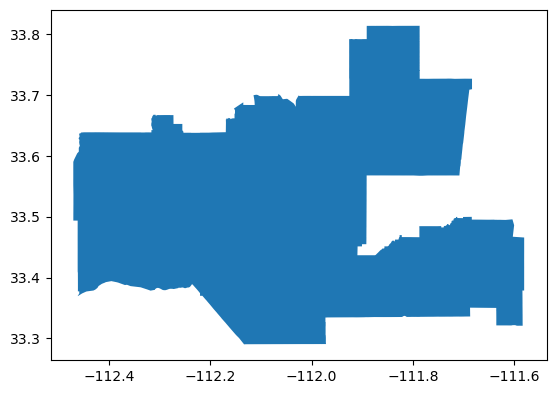

In [15]:
# Filter AZ shapefile to Phoenix
phx_shp = az_shp[az_shp["NAME"]=="Phoenix"]
# View Phoenix shapefile
phx_shp.plot()

Looks good! Now we can begin to manipulate our data.

## Data Processing

We want to isolate the rasters from the items to extract our data.

In [16]:
# Isolate the raster data from the item
rast_2020 = rioxr.open_rasterio(item_2020.assets["data"].href)

# Drop band for ease of processing
rast_2020 = rast_2020.squeeze().drop_vars("band")

In [17]:
# Isolate the raster data from the item
rast_2017 = rioxr.open_rasterio(item_2017.assets["data"].href)

# Drop band for ease of processing
rast_2017 = rast_2017.squeeze().drop_vars("band")

Now we can clip those rasters to our Phoenix shapefile.

In [18]:
# Clip raster to Phoenix bounds
phx_clip_2020 = (rast_2020.rio.clip_box(*phx_shp.total_bounds)
                .rio.clip(phx_shp.geometry))

In [19]:
# Clip raster to Phoenix bounds
phx_clip_2017 = (rast_2017.rio.clip_box(*phx_shp.total_bounds)
                .rio.clip(phx_shp.geometry))

With the data processed, we can visualize the raster overlayed over Phoenix.

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/ipykernel_55134/2513644849.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  phoenix_patch = mpatches.Patch(color=(0.1, 0.2, 0.5, 0.3), edgecolor="black", label="Phoenix Subdivision")


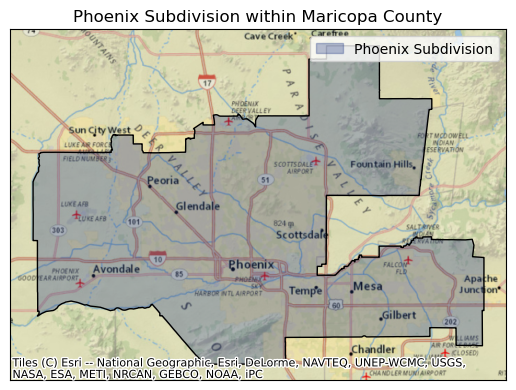

In [20]:
# Plot raster with Phoenix boundary
basemap = cx.providers.Esri.NatGeoWorldMap
fig, ax = plt.subplots()

# Plot the Phoenix boundary
phx_shp.plot(ax=ax, color=(0.1, 0.2, 0.5, 0.3), edgecolor="black")
cx.add_basemap(ax, crs=phx_shp.crs, source=basemap)

# Create a custom legend entry
phoenix_patch = mpatches.Patch(color=(0.1, 0.2, 0.5, 0.3), edgecolor="black", label="Phoenix Subdivision")
ax.legend(handles=[phoenix_patch], loc="upper right")

# Customize axis visibility
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Add a title
plt.title('Phoenix Subdivision within Maricopa County')

plt.show()

## BII Area Lost from 2017 to 2020

Now, we would like to investigate the impacts of urban expansion by exploring the differences in BIIs greater than .75 from our 2017 to 2020 rasters.

### Total Area of Phoenix

To calculate the difference in proportions, we first find the total area of the shapefile.

In [21]:
# Reproject to Phoenix CRS
phx_shp_projected = phx_shp.to_crs(epsg=2223)

# Calculate the total area
total_area = phx_shp_projected.geometry.area.sum() / 1e6  # In square kilometers
print(f"Total area of Phoenix subdivision: {total_area:.2f} square kilometers")

Total area of Phoenix subdivision: 30304.99 square kilometers


### Percent of Biodiverse Area

Next, we find the percent BII greater than .75 from each raster.

In [22]:
# Showing the area with BII>=0.75 in 2017 
phx_clip_2017_BII = (phx_clip_2017 >= 0.75)
phx_clip_2020_BII = (phx_clip_2020 >= 0.75)

In [23]:
# Calculate the number of pixels meeting the threshold
phx_2017_BII_area = phx_clip_2017_BII.sum().item()
phx_2020_BII_area = phx_clip_2020_BII.sum().item()

# Total number of pixels 
phx_2017_total_area = phx_clip_2017.count().item()
phx_2020_total_area = phx_clip_2020.count().item()

Now that we have percent BII greater than .75 for each raster, we can divide it by the total area to get the percentages of area with a BII of .75 or more.

In [24]:
# Calculate the percentage of the total area with BII >= 0.75
bii_pct_2017 = (phx_2017_BII_area / phx_2017_total_area) * 100
bii_pct_2020 = (phx_2020_BII_area / phx_2020_total_area) * 100

# Print the results
print(f"Percentage of area with BII >= 0.75 in 2017: {bii_pct_2017:.2f}%")
print(f"Percentage of area with BII >= 0.75 in 2020: {bii_pct_2020:.2f}%")
print(f"Difference in Percentage: {bii_pct_2017-bii_pct_2020:.2f}%")

Percentage of area with BII >= 0.75 in 2017: 7.13%
Percentage of area with BII >= 0.75 in 2020: 6.49%
Difference in Percentage: 0.63%


# Visualize

With our percentages calculated, we can begin to calculate the difference in BII.

In [25]:
# XOR operation: 1 for differing pixels, 0 for identical pixels
phx_flip = (phx_clip_2017_BII ^ phx_clip_2020_BII)
# Replace with 1 and nan for ease of visualization
phx_flip = xr.where(phx_flip, 1, np.nan)

With the raster created, we can visuallize the lost amongst the other rasters.

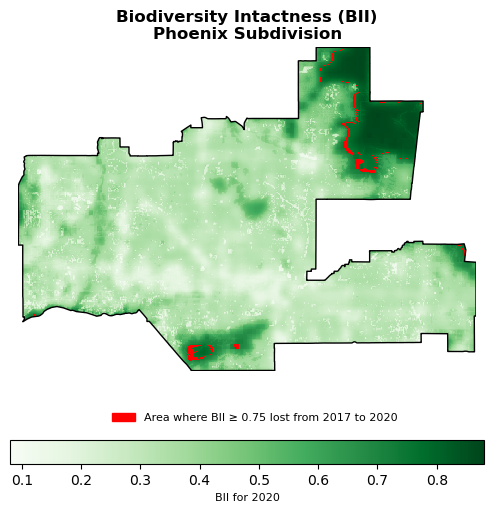

In [26]:
# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')

# Phx shape
phx_shp.boundary.plot(ax=ax,
                      edgecolor='black',
                      linewidth=1)

# Raster plot
bii_plot = phx_clip_2020.plot(ax=ax,
                              cmap='Greens',
                              cbar_kwargs={
                                  'location': 'bottom',  
                                  'label': 'BII for 2020',  
                                  'shrink': 0.51        
                              })

# Legend adjust
bii_plot.colorbar.set_ticks(np.arange(.1, .9, 0.1))
bii_plot.colorbar.ax.tick_params(labelsize=10)  
bii_plot.colorbar.set_label('BII for 2020', fontsize=8)  

# Plot BII diff
phx_flip.plot(ax=ax, 
              cmap='brg',
              add_colorbar=False)

# Legend adjust
bii_diff_leg = mpatches.Patch(color = "red", label = 'Area where BII ≥ 0.75 lost from 2017 to 2020')

# Legend adjust
ax.legend(handles = [bii_diff_leg], 
          fontsize = 8, 
          frameon=False, 
          bbox_to_anchor=(0.85, -0.1))

# Title and labels
ax.set_title('Biodiversity Intactness (BII)\nPhoenix Subdivision',
              fontsize=12, fontweight='bold')
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

plt.show()

## Discussion

We see that the change in biodiversity intactness above the threshold of 0.75 is less than 1%, specifically 0.63%. This figure may serve as a visual marker of current trends, as it may help in identifying areas at higher risk in the future. It is important to note that this does not mean the overall Biodiversity Intactness Index (BII) experienced less than a 1% difference. The threshold of 0.75 is arbitrary and only used for our analysis, and changes in biodiversity can vary significantly across different levels of intactness. Areas with a BII slightly below 0.75 might exhibit notable declines, even if these shifts did not cross our threshold. Additionally, while the threshold helps visualize at risk areas for conservation management, it does not capture the whole picture of ecosystem. Therefore, while our current analysis stands as a good starting point, using multiple thresholds or analyzing the full range of BII values can offer a better understanding of biodiversity trends.